# Version 0.0: use DNN to learn linear relation

## Why is it interesting?

We start from the simplest relation between signal and tissue properties that can be found in DWI:

$$
\log{S} = -bD \; ,
$$

where $\log{S}$ is the logarithm of the normalized signal, $b$ the diffusion-weighting (a property of the acquisition protocol), $D$ is the *apparent diffusion coefficient* (ADC - a property of the imaged tissues).

The relevance of this model is that provides the analytic solution to the ADC estimation problem (in the absence of noise).

Although DNN are ment to define non-linear relations between input and output, here we design the simplest NN which can define a linea relation between input and output.

We do so to understan how to work with tensorflow as well as to create an enviornament for developing more complex models.


For a given protocol, with a prescribed value of $b$, once $S$ is measured, we can determine the ADC via:

$$
D = - \frac{log{S}}{b} \; .
$$


## 0 Importing the modules

The first step is to import the relevant python modules.
Here we use:
* numpy
* matplotlib
* tensorflow
* sklearn (this is for manage training and validation data).
* ...

We also try to make sure that the module versions we are using are those we expect (check [here](https://github.com/garyhuizhang/DNN) for more info).

### 0.1 Google Colab compatibility

**(Skip this step if you are on a Jupyter Notebook)**

If you are running this code on Google Colab you need to:

1. Create a folder within your own Google Drive named "DNN_project".
2. Uncomment the following piece of code and run it.
3. You will be asked to mount your Google Drive and you will need to follow the steps prompted to you.

In [ ]:
"""
from google.colab import drive
import os

drive.mount('/content/drive')

%cd /content/drive/My Drive/DNN_project
if not os.path.isdir('dnn_test'):
  ! git clone https://github.com/micGuerr/dnn_test.git

%cd dnn_test
! git pull
%cd python

! chmod +x import_modules.sh
! ./import_modules.sh
"""

In [1]:
import numpy as np
from numpy.random import default_rng # this is needed for random extractions

import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split

from utils.training_utils import PlotLearning


print("Numpy version = " + np.__version__)
print("Matplotlib version = " + matplotlib.__version__)
print("Tensorflow version = " + tf.__version__)
print("Keras version = " + keras.__version__)

Numpy version = 1.19.5
Matplotlib version = 3.4.3
Tensorflow version = 2.6.0
Keras version = 2.6.0


## 1 Synthesise training/validation data from ADC model

In this demo we use synthetic data, so that there is a known groundtruth.

**How to sample the training/validation data?**

There can be a variety of different ways to do this.  It is not immediately clear the best way.

**Should the samples be uniformly spaced?**

Over the signal space ($\log{S}$) or the parameter space ($d$)?

**Should the samples be drawn from an uniform distribution?**

Again over the signal space ($\log{S}$) or the parameter space ($d$)?

### 1.1 First trying uniformly spaced samples over the parameter space


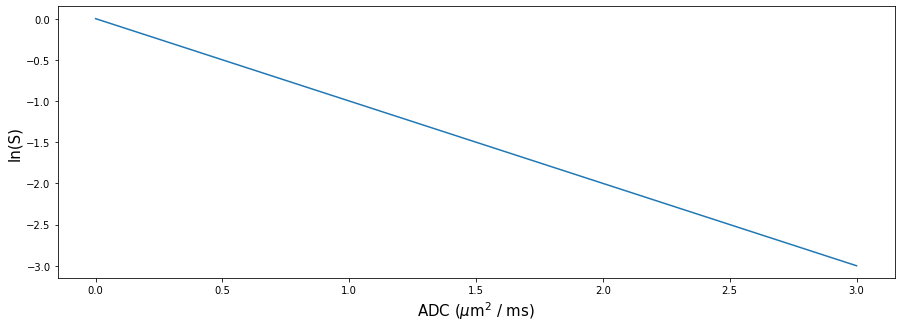

In [2]:
# Create uniform distribution of diffusion values between 0 and 3 [um^2/ms] with increment of 0.01
inc = 0.01
d = np.arange(0,3+inc,inc)

# number of samples
numOfSamples = d.size

# The b-value [ms / um^2]
b = 1

# The log of the signal
lnS = - d*b

# Let's have a look at the signal vs ADC
plt.rcParams['figure.figsize'] = [15, 5]
plt.plot(d, lnS)
plt.xlabel('ADC ($\mu$m$^{2}$ / ms)', size=15)
plt.ylabel('ln(S)', size=15)
plt.show()


## 2 Test and validation data

In this step we split synthesised data into the training and validation set.
We use a **Hold-out** approach in which a part of the dataset (~ $20\%$) that is not used for training is used for validation.
 
Note that we fixed the random seed to ease comparison across multiple setups.

In [3]:
x_train, x_test, y_train, y_test = train_test_split(
...     lnS, d, test_size=0.2, random_state=3)

print('Training input: ', x_train[0:10])
print('Input labels: ', y_train[0:10])
print('Validation input: ', x_test[0:10])
print('Validation labels: ', y_test[0:10])

Training input:  [-1.42 -0.37 -0.03 -1.36 -2.95 -2.31 -0.64 -1.96 -0.5  -0.23]
Input labels:  [1.42 0.37 0.03 1.36 2.95 2.31 0.64 1.96 0.5  0.23]
Validation input:  [-1.51 -2.14 -2.51 -0.25 -1.94 -2.57 -0.66 -1.26 -0.16 -2.36]
Validation labels:  [1.51 2.14 2.51 0.25 1.94 2.57 0.66 1.26 0.16 2.36]


## 3 Build the minimal DNN

In this step we define the DNN model.

For this task we define a feedforward model with one input and one output layer. No activation funtion is used, as the response is expected to be linear.

Also, we do not use any bias parameter in this fit.

The input of the model is the logarithm of the signal for each voxel.

In [4]:
model = keras.Sequential([
    keras.layers.Input(shape=(1,), name="LogSignal"),  # input layer (1)
    keras.layers.Dense(1, use_bias=False, name="ADC"),  # output layer (2)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ADC (Dense)                  (None, 1)                 1         
Total params: 1
Trainable params: 1
Non-trainable params: 0
_________________________________________________________________


In [5]:
# extra step to allow graphviz to be found 

#ann_viz(model, view=True, filename="dnn_version0", title="Linear network")

## 4 Model compilation

The next step is to compile the model, i.e. to definedifferent aspects of hoe the model is going to be trained, such as the optimization algorithm and loss function.

We use *stochastic gradient descent* as optimizer.

We use *mean squared error* as loss function.

We also define some *callbacks* which are going to be called at the end of each epoch. The two defined here allow to stop the training earlier if no improvements are made in the training and to live plotting the training and validation output.

**Questions**

What is the right learning rate?

Are there other metrics I should consider?

In [6]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-2), 
              loss='mse',
             metrics="RootMeanSquaredError")

# Stop training when a monitored metric has stopped improving.
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

# Get a list of Callbacks
callbacks_list = [PlotLearning(), earlyStop]


## 5 Model fitting

Here is where the training of the model happen.

In this implementation we use the following specifics:
* We fix the random seed.
* We use 2000 epochs (but we can stop earlier if there is no improvement).
* We assess the performance of the model on-line via the validation set.
* We randomly shuffle the data. This is to avoid that the network recive the data always in the same arrangement.
* We call the list of callbacks defined in the previous step

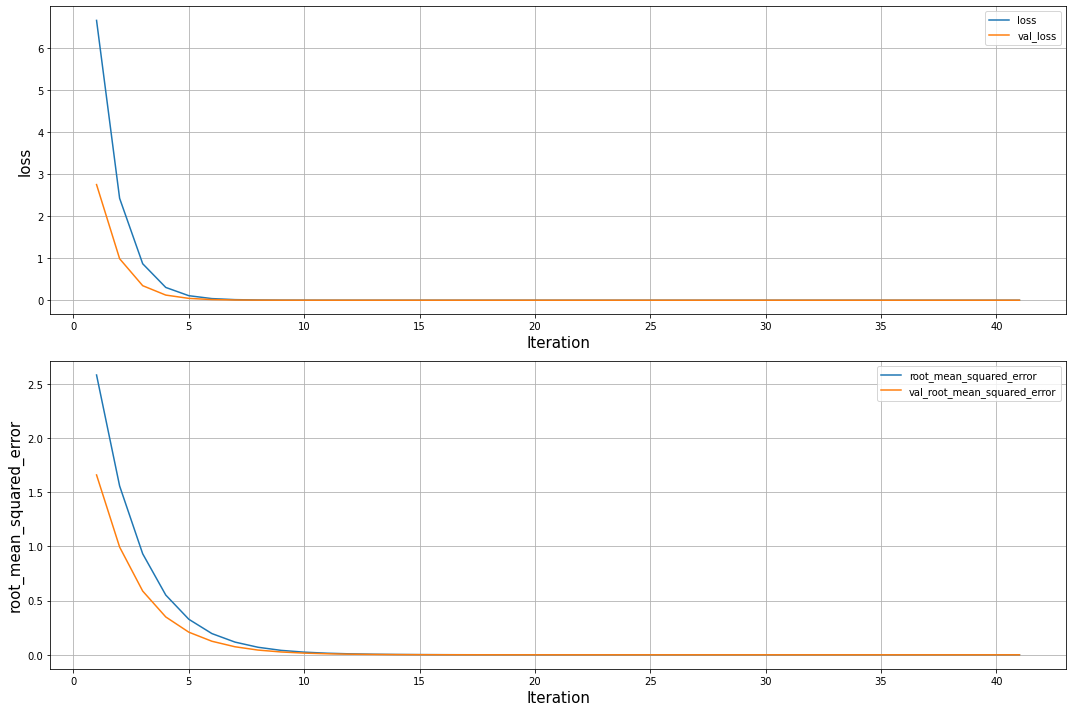

In [7]:
# fix the random seed to ease comparison across multiple setups
tf.random.set_seed(3) # at the moment I am not sure this does the right thing. I should write an ad-hoc callback to check it.

# run the training
history = model.fit(x_train,
                    y_train,
                    epochs=2000,
                    validation_data=(x_test, y_test),
                    shuffle=True,
                    callbacks=callbacks_list )

## 6 Visualize the fitting quality

Here we compare the predictions from the validation set with the plot of the test set (signal) vs the input labels (ADC).

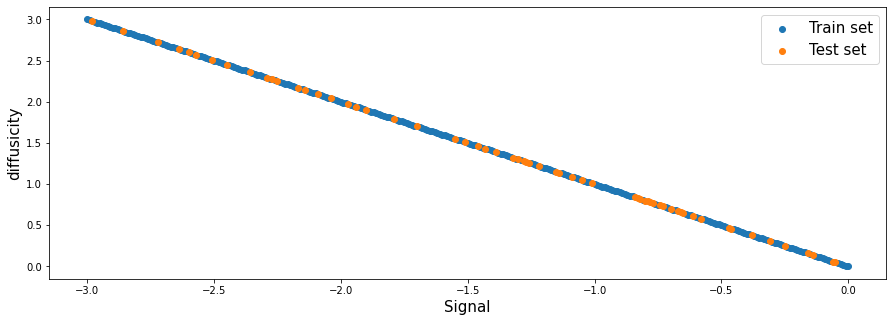

In [8]:
predictions = model.predict(x_test)


plt.rcParams['figure.figsize'] = [15, 5]
plt.scatter(x_train, y_train)
plt.xlabel("Signal", size=15)
plt.ylabel("diffusicity", size=15)
plt.scatter(x_test, predictions)
plt.legend(['Train set', 'Test set'],  prop={'size': 15})

## 7 Inspect the trained network

In this section we inspect how each layer affect the input data.

We also report the value of te weights foe each leayer

In [1]:
# Get the number of layers
n_layers = len(model.layers)

# Input layer is always the Signal (log)
layerNames = ['log(Signal)']
plt.scatter(x_train, x_train) # plot it's identity line

# Run through the leyers and store them into the "extractor" object
extractor = keras.Model(inputs=model.inputs,
                        outputs=[layer.output for layer in model.layers])
# Let the training set go trough the layers and store each layer output
features = extractor(x_train)

# loop over the layers to plot the output
for i in range(n_layers):
    # if there is only one layer, "features" is a keras tensor object
    if tf.is_tensor(features):
        f = features
    # otherwise, it is a list of keras tensors
    else:
        f = features[i]
    # If there is more than one unit per layer the keras tensor is organized as #inputsX#units
    # here we store the number of unit per layer
    feat_dim = f.shape[1]
    # if width > 1, we plots the outputs of all the units per layer
    if feat_dim > 1:
        for j in range(feat_dim):
            plt.scatter(x_train, f[:,j])
            layerNames.append(model.layers[i].name + "_unit" + str(j))
    # otherwise, we plot the output of the layer
    else:
        plt.scatter(x_train, f[:])
        layerNames.append(model.layers[i].name)

# Make the plot look nicer
plt.xlabel('Signal', size=15)
plt.ylabel('Activation', size=15)
plt.legend(layerNames,  prop={'size': 15})

# Print the weights
weights = model.get_weights()
print("Weights are", weights)

NameError: name 'model' is not defined

## 8 Conclusion

The model does what expected.